# Travelling Salesman

This notebook tests several solutions to the travelling salesman problem. Note that the actual implementations can be found in the corresponding Python module.

_Approaches_:
* **Random**: This is not really a solution, just a weak benchmark
* **Greedy (Nearest Neighbour)**: This is a simple heuristic that actually produces a tough benchmark to beat
* **Simulated Annealing**: SA can produces solutions that beat the greedy approach, but (1) every new set of coordinates requires parameter calibration (so you might need to run hyperparameter tuning for each set of coordinates) and (2) it tends to get more unstable as the number of coordinates goes up
* **Monte Carlo Tree Search**: The below results look pretty poor, but this algorithm really does work except it doesn't scale well (at least that can be said about my implementation). The biggest scaling challenge is that every simulation has to map and reduce the entire lookup table twice, once to get the root-length entries and the other to get the root-length + 1 (extension) entries. The algorithm certainly has potential but it easily gets trapped in local mimima with few simulations whereas with many simulations it faces serious scaling issues

On the to-do list:
* **Linear Programming**
* **Generic algorithm**
* **Dijkstra algorithm**
* **Network**
* **Concorde**

# Setup

In [264]:
%reload_ext autoreload
%autoreload 2

import os
import sys
import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import pandas as pd
from inspect import signature
from typing import List, Dict

# need to tell the interpreter where to find the module
module_dir = os.path.dirname(os.getcwd())
if module_dir not in sys.path:
    sys.path.append(module_dir)

from tsp import evaluation, coordinates, tools
from tsp.coordinates import Coordinate
from tsp.strategies import (  # these are defined in strategies.__init__
    find_path_random,
    find_path_greedy,
    find_path_sa,
    find_path_mcts,
)

In [268]:
COORDINATE_DIM = 20

strategies_to_use = [
    ("random", find_path_random, {}),
    ("greedy", find_path_greedy, {}),
    ("sa", find_path_sa, {"iterations": 100000, "temperature_scale": 150, "cooling": 0.0025}),
    ("mcts", find_path_mcts, {"sims": 10, "exploration_criterion": 10})
]

# a sample of coordinates to use for evaluation
sample_coordinates = coordinates.create_coordinates(COORDINATE_DIM)

# paths built with various solutions (this may take a while to run)
paths = {
    label: tools.timer(strategy)(sample_coordinates, **argdict) 
    for label, strategy, argdict in strategies_to_use
}

# distance + time
solutions = {
    label: (evaluation.get_total_distance(contents["result"]["path"]), contents["elapsed"]) 
    for label, contents in paths.items()
}

# Explore solutions

## Chosen paths

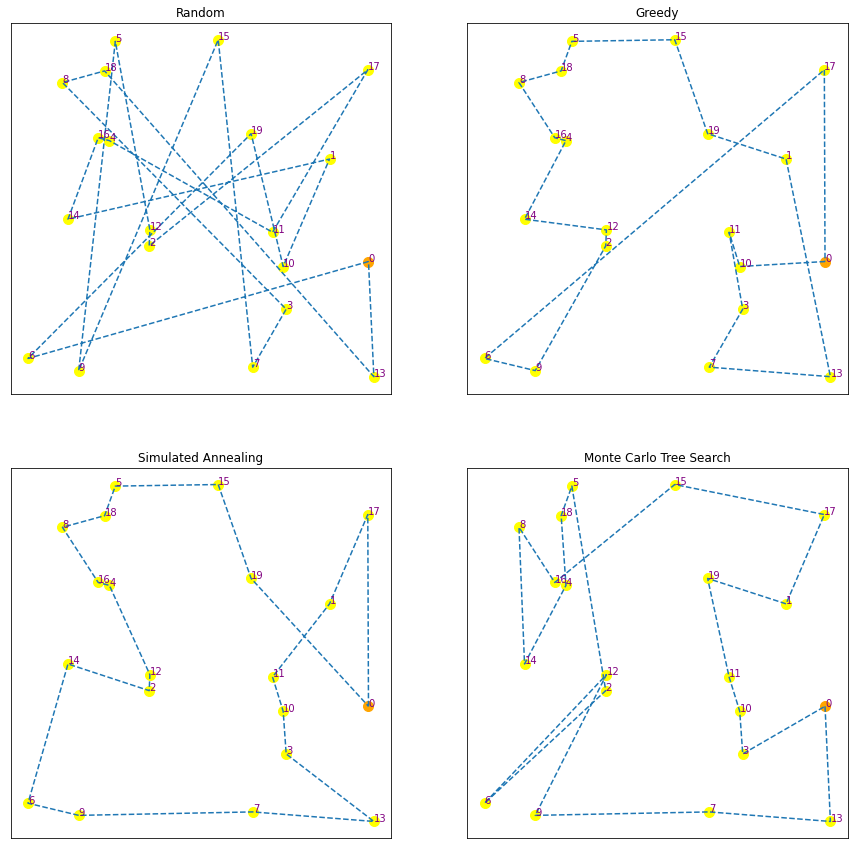

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

<Figure size 576x504 with 0 Axes>

In [269]:
# Explore the paths
plt.close('all')
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
gs = gridspec.GridSpec(ncols=2, nrows=2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax3 = fig.add_subplot(gs[1, 0])
ax4 = fig.add_subplot(gs[1, 1])
evaluation.plot_destinations(paths["random"]["result"]["path"], "Random", ax1)
evaluation.plot_destinations(paths["greedy"]["result"]["path"], "Greedy", ax2)
evaluation.plot_destinations(paths["sa"]["result"]["path"], "Simulated Annealing", ax3)
evaluation.plot_destinations(paths["mcts"]["result"]["path"], "Monte Carlo Tree Search", ax4)

## Distance and time comparisons

Text(0.5, 0, 'Time in seconds')

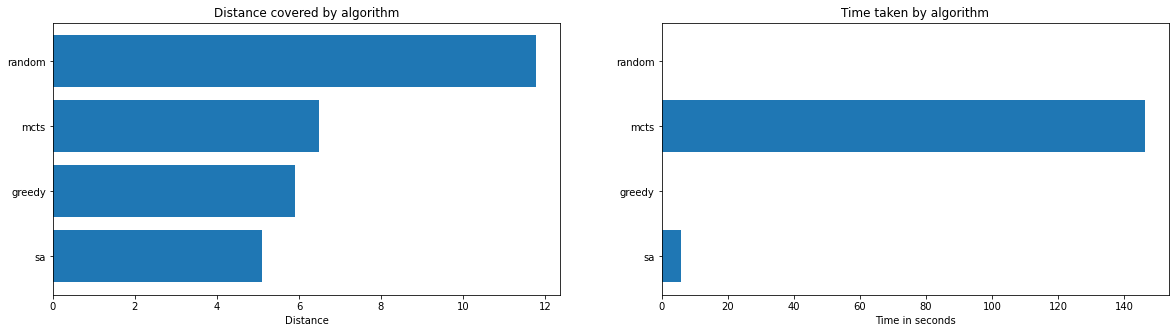

In [270]:
performance_results = (
    pd.DataFrame
    .from_dict(solutions)
    .join(pd.DataFrame({"measure": ["distance","time"]}))
    .melt(id_vars="measure", value_vars=solutions.keys())
    .pivot(index="variable", columns="measure", values="value")
    .reset_index()
    .rename(columns={"variable": "algorithm"})
    .sort_values("distance")
)

plt.close('all')
fig = plt.figure()
fig.set_figheight(5)
fig.set_figwidth(20)
gs = gridspec.GridSpec(ncols=2, nrows=1, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[0, 1])
ax1.barh(performance_results["algorithm"], performance_results["distance"])
#ax1.bar_label(ax1.containers[0])
ax1.set_title("Distance covered by algorithm")
ax1.set_xlabel("Distance")
ax2.barh(performance_results["algorithm"], performance_results["time"])
#ax2.bar_label(ax2.containers[0])
ax2.set_title("Time taken by algorithm")
ax2.set_xlabel("Time in seconds")

# Performance history of iterative solutions

Text(0.5, 1.0, 'MCTS History')

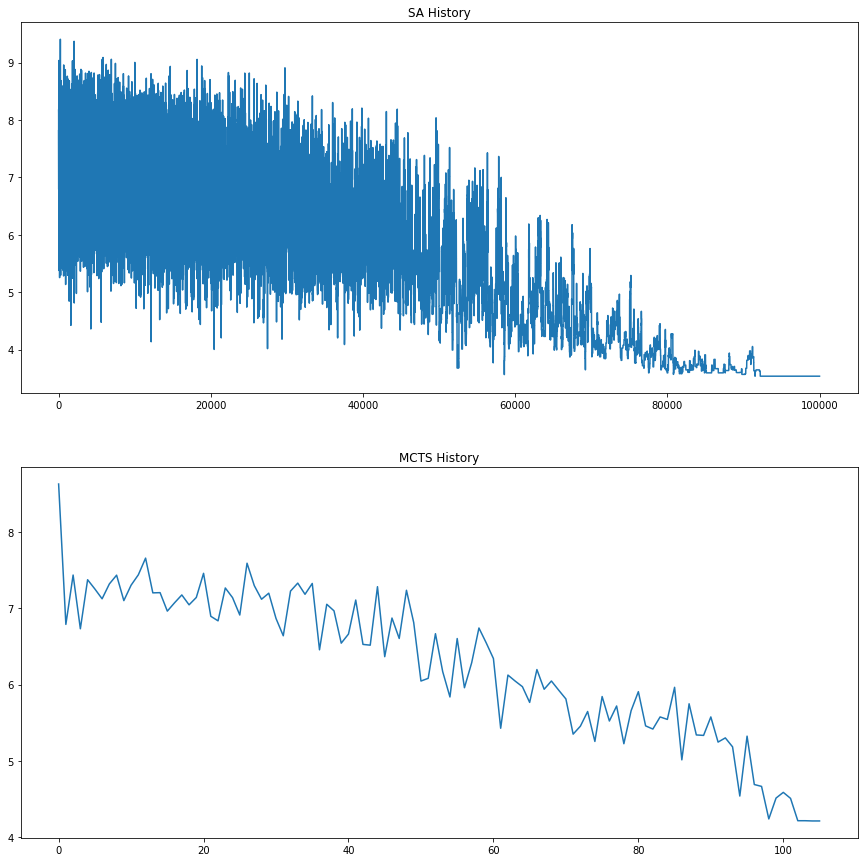

In [263]:
plt.close('all')
fig = plt.figure()
fig.set_figheight(15)
fig.set_figwidth(15)
gs = gridspec.GridSpec(ncols=1, nrows=2, figure=fig)
ax1 = fig.add_subplot(gs[0, 0])
ax2 = fig.add_subplot(gs[1, 0])
ax1.plot(paths["sa"]["result"]["history"])
ax1.set_title("SA History")
ax2.plot(paths["mcts"]["result"]["history"])
ax2.set_title("MCTS History")